# **Berikut adalah tahapan hasil training dataset yang sudah dilatih menggunakan Google Colabs**

## Tahap 0: Aktivasi GPU & Cek Lingkungan
Langkah pertama dan paling penting di Colab.

1. Di menu atas, klik Runtime.
2. Pilih Change runtime type.
3. Di bawah Hardware accelerator, pilih T4 GPU.
4. Klik Save.

Sel di bawah ini akan memverifikasi bahwa GPU sudah terdeteksi.

In [3]:
# Sel 1: Cek Ketersediaan GPU
import tensorflow as tf
import os

print("Versi TensorFlow:", tf.__version__)
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    print("GPU tersedia:", gpu_devices)
    print("Training akan menggunakan GPU.")
else:
    print("PERINGATAN: GPU TIDAK DITEMUKAN. Pastikan Anda sudah mengaktifkannya di Runtime > Change runtime type.")

# Perintah ini akan menampilkan detail GPU
!nvidia-smi

Versi TensorFlow: 2.19.0
GPU tersedia: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Training akan menggunakan GPU.
Tue Oct 28 14:43:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|  

## Tahap 1: Instalasi Library & Download Dataset
Di sini kita akan menginstal library yang Anda butuhkan (yang tidak ada di Colab secara default) dan mengunduh serta mengekstrak dataset .zip Anda dari Google Drive.

In [4]:
# Sel 2: Instalasi Library (dari file Anda)
# TensorFlow sudah terinstal di Colab, jadi kita skip !pip install tensorflow
!pip install -q tqdm opencv-python scikit-image scikit-learn

In [5]:
# Sel 3: Download & Ekstrak Dataset dari Google Drive
!pip install -q gdown  # Install gdown untuk download dari GDrive

# Mount Google Drive Anda (untuk MENYIMPAN hasil model nanti)
from google.colab import drive
drive.mount('/content/drive')

# File ID dari link Google Drive yang Anda berikan
file_id = "19GWEC95BAftlFKOsSztSCUk76ceTlVlt"
output_zip = "dataset_batik_fix.zip"
extract_path = "/content/dataset/"  # Path di dalam Colab

# Download file
!gdown --id {file_id} -O {output_zip}

# Buat folder tujuan dan ekstrak
import zipfile
os.makedirs(extract_path, exist_ok=True)

print(f"Mengekstrak '{output_zip}' ke '{extract_path}'...")
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Ekstraksi selesai.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19GWEC95BAftlFKOsSztSCUk76ceTlVlt
From (redirected): https://drive.google.com/uc?id=19GWEC95BAftlFKOsSztSCUk76ceTlVlt&confirm=t&uuid=ff0395af-22df-4b26-bb0a-62cf1c8e080f
To: /content/dataset_batik_fix.zip
100% 2.09G/2.09G [00:21<00:00, 96.2MB/s]
Mengekstrak 'dataset_batik_fix.zip' ke '/content/dataset/'...
Ekstraksi selesai.


## Tahap 2: Setup Environment & Path (dari file Anda)
Sel ini sama dengan "Tahap 2 & 3" di notebook Anda. Saya hanya akan mengubah path agar sesuai dengan lokasi file di Colab.

In [6]:
# Sel 4: Setup Environment (Impor library)
# (Diambil dari sel '153cc797' di file Anda)

import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight # Untuk Tahap 6 (Opsional)
import tensorflow as tf
from tensorflow.keras import Model, layers, models, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Input, InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
# Sel 5: Menentukan Parameter Utama
# (Diambil dari sel 'd15c16e3' di file Anda)

IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,) # Menambahkan channel warna (3 untuk RGB)
BATCH_SIZE = 32

In [8]:
# Sel 6: Menentukan Path Dataset (VERSI COLAB)
# (Modifikasi dari sel '77a3b45b' di file Anda)

# Path LOKAL Anda adalah: "dataset/dataset_batik_fix/processed_dataset"
# Kita ganti menjadi path di Colab tempat kita mengekstrak file
dataset_dir = "/content/dataset/dataset_batik_fix/processed_dataset" # <--- PERUBAHAN
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

# Cek apakah direktori ada
if not os.path.exists(train_dir):
    print(f"Error: Direktori train tidak ditemukan di {train_dir}")
if not os.path.exists(test_dir):
    print(f"Error: Direktori test tidak ditemukan di {test_dir}")
    # (Saya ikuti logika Anda jika test_dir tidak ada)
    test_dir = train_dir

print(f"Path Train: {train_dir}")
print(f"Path Test: {test_dir}")

Path Train: /content/dataset/dataset_batik_fix/processed_dataset/train
Path Test: /content/dataset/dataset_batik_fix/processed_dataset/test


## Tahap 3 & 4: Memuat Dataset & Augmentasi (dari file Anda)
Ini adalah sel-sel dari "Tahap 4, 5, 6" di notebook Anda. Path-nya sudah benar karena kita atur di sel sebelumnya.

In [9]:
# Sel 7: Memuat & Membagi Dataset Training/Validasi
# (Diambil dari sel 'ec828888' di file Anda)
# Path 'train_dir' sudah kita update di sel sebelumnya

print("Memuat data training dan validasi...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

Memuat data training dan validasi...
Found 8340 files belonging to 20 classes.
Using 6672 files for training.
Found 8340 files belonging to 20 classes.
Using 1668 files for validation.


In [10]:
# Sel 8: Memuat Dataset Testing
# (Diambil dari sel '2209cb40' di file Anda)
# Path 'test_dir' sudah kita update di sel sebelumnya

print("Memuat data testing...")
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False # Penting untuk evaluasi
)

Memuat data testing...
Found 300 files belonging to 20 classes.


In [11]:
# Sel 9: Mendapatkan Nama Kelas
# (Diambil dari sel 'ee96ed46' di file Anda)

class_names = train_dataset.class_names
print(f"Total kelas ditemukan: {len(class_names)}")
print("Nama Kelas:", class_names)

Total kelas ditemukan: 20
Nama Kelas: ['batik_betawi', 'batik_bokor_kencono', 'batik_buketan', 'batik_dayak', 'batik_jlamprang', 'batik_kawung', 'batik_liong', 'batik_mega_mendung', 'batik_parang', 'batik_sekarjagad', 'batik_sidoluhur', 'batik_sidomukti', 'batik_sidomulyo', 'batik_singa_barong', 'batik_srikaton', 'batik_tribusono', 'batik_tujuh_rupa', 'batik_tuntrum', 'batik_wahyu_tumurun', 'batik_wirasat']


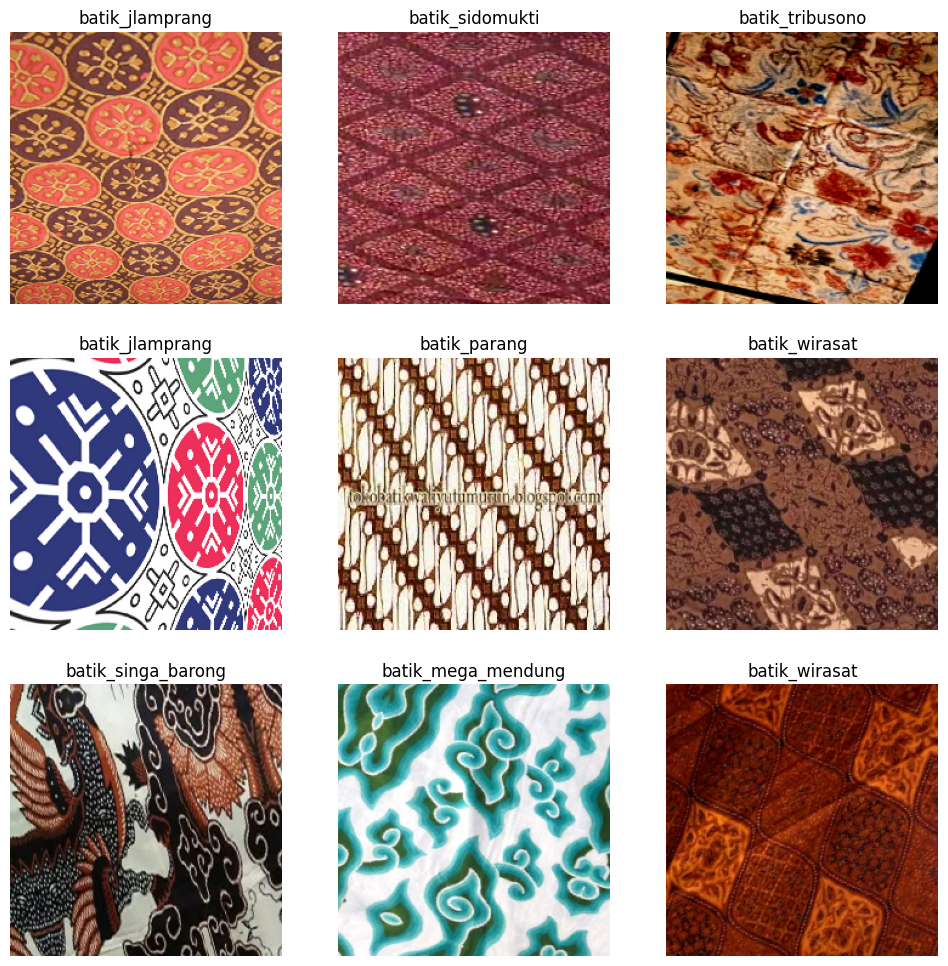

In [12]:
# Sel 10: Visualisasi Data Latih
# (Diambil dari sel '61a1d9ac' di file Anda)

plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(min(9, BATCH_SIZE)):  # Tampilkan maksimal 9 gambar
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [13]:
# Sel 11: Membuat Lapisan Augmentasi
# (Diambil dari sel 'c62f2759' di file Anda)

data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical", seed=42),
    layers.RandomRotation(0.2, seed=42),
    layers.RandomZoom(0.2, seed=42),
    layers.RandomContrast(0.2, seed=42)
], name="data_augmentation")

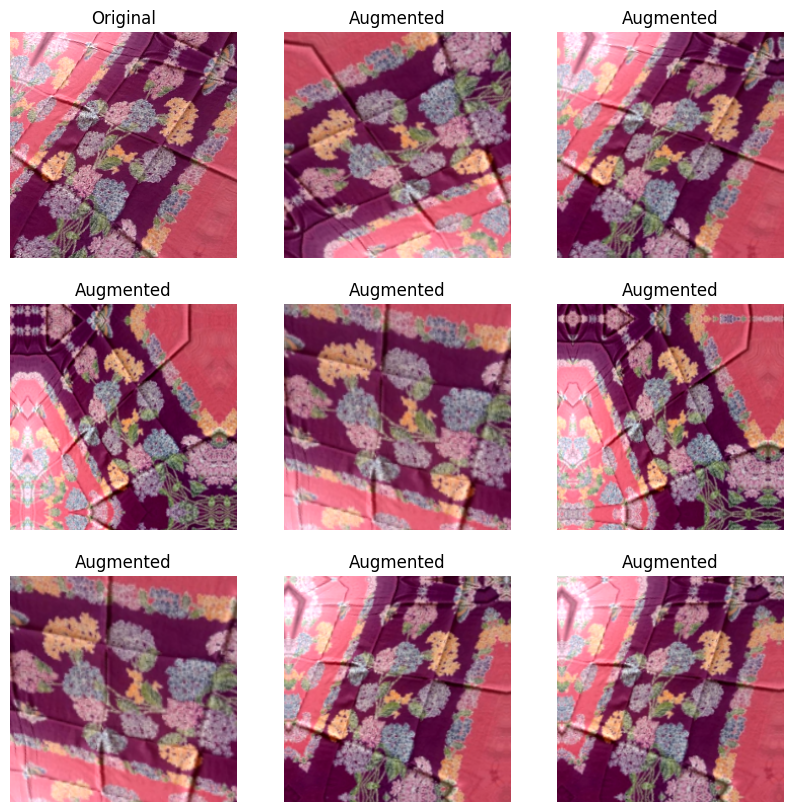

In [14]:
# Sel 12: Visualisasi Augmentasi
# (Diambil dari sel '500ab435' di file Anda)

# Ambil satu gambar untuk dites
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    first_image = images[0]
    plt.subplot(3, 3, 1)
    plt.imshow(first_image.numpy().astype('uint8'))
    plt.title("Original")
    plt.axis('off')

    # Terapkan augmentasi 8x
    for i in range(8):
        ax = plt.subplot(3, 3, i + 2)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
        plt.imshow(augmented_image[0].numpy().astype('uint8'))
        plt.title("Augmented")
        plt.axis('off')
plt.show()

##Tahap 5: Membangun Pipeline Data (dengan Optimasi)
Ini adalah "Tahap 7" dari notebook Anda. Saya akan menambahkan .cache() dan .prefetch() di sini. Ini adalah optimasi krusial untuk Colab agar GPU tidak "menunggu" data.

In [15]:
# Sel 13: Membangun Pipeline Data (Optimasi COLAB)
# (Modifikasi dari sel '917a26ad' & '8903c737' di file Anda)

# Definisikan fungsi pre-processing dari file Anda
def preprocess_train(image, label):
    image = data_augmentation(image, training=True)
    image = layers.Rescaling(1./255)(image) # Normalisasi
    return image, label

def preprocess_val(image, label):
    image = layers.Rescaling(1./255)(image) # Normalisasi (tanpa augmentasi)
    return image, label

# Tentukan AUTOTUNE untuk pipeline yang efisien
AUTOTUNE = tf.data.AUTOTUNE

# Terapkan .map() dari file Anda
train_dataset_mapped = train_dataset.map(preprocess_train, num_parallel_calls=AUTOTUNE)
validation_dataset_mapped = validation_dataset.map(preprocess_val, num_parallel_calls=AUTOTUNE)

# --- OPTIMASI PENTING UNTUK COLAB/GPU ---
# .cache(): Menyimpan data di memori setelah epoch pertama
# .prefetch(): Membuat CPU menyiapkan batch data berikutnya saat GPU sedang melatih
print("Menerapkan optimasi .cache() dan .prefetch()...")
train_dataset_opt = train_dataset_mapped.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset_opt = validation_dataset_mapped.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset_opt = test_dataset.map(preprocess_val, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)

print("Pipeline data siap.")

Menerapkan optimasi .cache() dan .prefetch()...
Pipeline data siap.


## Tahap 6: (Opsional) Menghitung Class Weights
Di prompt pertama Anda, Anda menyebut class_weight. Ini tidak ada di file notebook Anda, tapi ini adalah ide yang sangat bagus jika dataset Anda tidak seimbang. Saya akan tambahkan kodenya di sini.

Jika Anda tidak mau menggunakannya, ubah USE_CLASS_WEIGHTS = True menjadi False.

In [16]:
# Sel 14: (Opsional) Hitung Class Weights
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

USE_CLASS_WEIGHTS = True  # Ganti jadi False jika tidak ingin pakai

if USE_CLASS_WEIGHTS:
    print("Menghitung class weights...")
    # Kita perlu mengekstrak semua label dari train_dataset
    # Ini mungkin butuh beberapa saat
    all_labels = []
    for _, labels in train_dataset:
        all_labels.extend(labels.numpy())

    all_labels = np.array(all_labels)

    # Hitung weights
    class_weights_array = compute_class_weight(
        'balanced',
        classes=np.unique(all_labels),
        y=all_labels
    )

    # Ubah ke format dictionary yang diterima Keras
    class_weights = dict(enumerate(class_weights_array))

    print("Class weights berhasil dihitung:")
    print(class_weights)
else:
    print("Class weights tidak digunakan.")
    class_weights = None

Menghitung class weights...
Class weights berhasil dihitung:
{0: np.float64(0.9782991202346041), 1: np.float64(0.9958208955223881), 2: np.float64(0.9613832853025936), 3: np.float64(1.1543252595155709), 4: np.float64(1.0523659305993691), 5: np.float64(0.9958208955223881), 6: np.float64(0.9811764705882353), 7: np.float64(0.9958208955223881), 8: np.float64(1.023312883435583), 9: np.float64(1.0170731707317073), 10: np.float64(0.9811764705882353), 11: np.float64(0.9988023952095808), 12: np.float64(0.9958208955223881), 13: np.float64(0.9697674418604652), 14: np.float64(0.984070796460177), 15: np.float64(0.9754385964912281), 16: np.float64(0.9958208955223881), 17: np.float64(0.9669565217391304), 18: np.float64(1.0048192771084337), 19: np.float64(1.0018018018018018)}


## Tahap 7: (Opsional) Mengaktifkan Mixed Precision
Ini adalah optimasi tambahan untuk GPU T4 di Colab. Ini akan membuat training 2-3x lebih cepat dan menghemat memori.

In [17]:
# Sel 15: (Opsional) Aktifkan Mixed Precision
# Mempercepat training di GPU T4
from tensorflow.keras import mixed_precision

# Mengatur kebijakan global untuk menggunakan mixed precision
try:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print('Kebijakan Mixed Precision diatur ke "mixed_float16".')
except Exception as e:
    print(f"Gagal mengatur mixed precision: {e}")
    print("Melanjutkan dengan presisi standar (float32).")

Kebijakan Mixed Precision diatur ke "mixed_float16".


##Tahap 8: Definisi Fungsi Plot
Notebook Anda memanggil plot_history tapi tidak mendefinisikannya. Saya akan tambahkan definisinya di sini.

In [18]:
# Sel 16: Definisi Fungsi plot_history
# (Fungsi ini dipanggil di notebook Anda tapi tidak ada definisinya)

def plot_history(history, title):
    """Plots training & validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'Akurasi Training & Validasi - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'Loss Training & Validasi - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

## Tahap 9: Sesi Pelatihan Model 1-8 (dari file Anda)
Ini adalah inti dari notebook Anda. Saya akan menyalin semua 8 arsitektur model dan loop pelatihannya. Saya akan menggunakan train_dataset_opt dan validation_dataset_opt yang sudah kita optimasi.

Saya juga menambahkan %time di setiap sel .fit() agar Anda bisa melihat berapa lama waktu yang dibutuhkan di Colab.

### **Model 1: Baseline (CNN Sederhana)**

In [19]:
# Sel 17: Definisi Model 1
# (Diambil dari sel 'b35e05a8')

model_1 = Sequential([
    layers.Input(shape=IMG_SHAPE),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax', dtype=tf.float32) # Output layer disarankan float32 untuk stabilitas
])

# Sel 18: Kompilasi Model 1
# (Diambil dari sel '87864f16')
model_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Sesuai dengan label_mode='int'
    metrics=['accuracy']
)

model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,964,692 (45.64 MB)

 Trainable params: 11,964,692 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Sel 19: Pelatihan Model 1
# (Diambil dari sel '537b8d80')

print("Memulai pelatihan Model 1...")
%time
history_1 = model_1.fit(
    train_dataset_opt,  # Menggunakan dataset yang dioptimasi
    epochs=30,          # Sesuai file Anda
    validation_data=validation_dataset_opt, # Menggunakan dataset yang dioptimasi
    class_weight=class_weights # Menggunakan class weights (opsional)
)

Memulai pelatihan Model 1...
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
Epoch 1/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 112s 445ms/step - accuracy: 0.1207 - loss: 4.1691 - val_accuracy: 0.2482 - val_loss: 2.3794
Epoch 2/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.3294 - loss: 2.1496 - val_accuracy: 0.3243 - val_loss: 2.1926
Epoch 3/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5641 - loss: 1.4124 - val_accuracy: 0.3657 - val_loss: 2.4390
Epoch 4/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.7690 - loss: 0.7807 - val_accuracy: 0.3177 - val_loss: 3.1610
Epoch 5/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8840 - loss: 0.4492 - val_accuracy: 0.3753 - val_loss: 3.0471
Epoch 6/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9289 - loss: 0.2612 - val_accuracy: 0.3723 - val_loss: 3.9961
Epoch 7/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9704 - loss: 0.1238 - val_accuracy: 0.3615 - val_loss: 4.0183


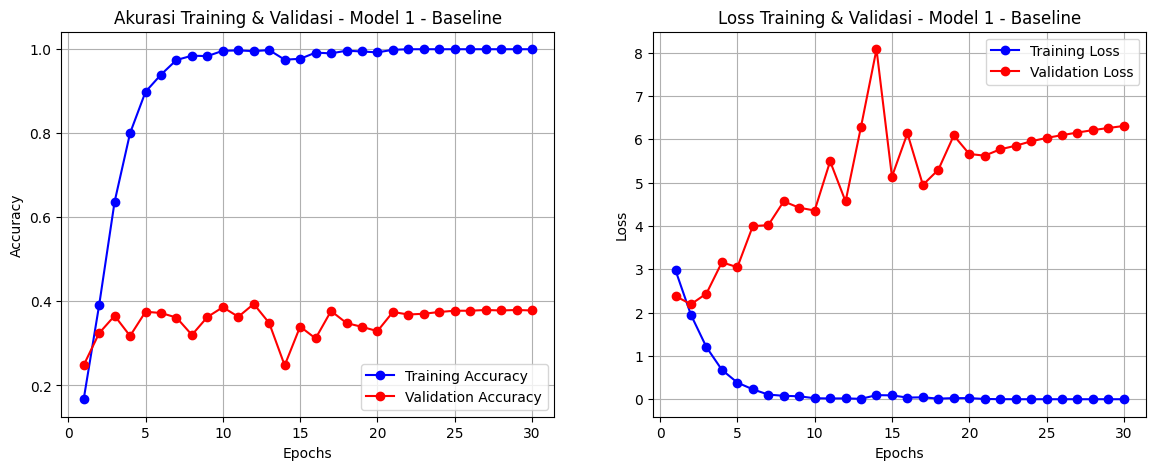

In [21]:
# Sel 20: Plot Hasil Model 1
# (Diambil dari sel '12e4f014')
plot_history(history_1, "Model 1 - Baseline")

### **Model 2: Menambah Dropout**

In [22]:
# Sel 21: Definisi Model 2
# (Diambil dari sel '19b0d62d')

model_2 = Sequential([
    layers.Input(shape=IMG_SHAPE),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5), # Tambah Dropout
    layers.Dense(len(class_names), activation='softmax', dtype=tf.float32)
])

# Sel 22: Kompilasi Model 2
# (Diambil dari sel '1832049d')
model_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,964,692 (45.64 MB)

 Trainable params: 11,964,692 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Sel 23: Pelatihan Model 2
# (Diambil dari sel 'cefa556a')

print("Memulai pelatihan Model 2...")
%time
history_2 = model_2.fit(
    train_dataset_opt,
    epochs=30,
    validation_data=validation_dataset_opt,
    class_weight=class_weights
)

Memulai pelatihan Model 2...
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.72 µs
Epoch 1/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.0587 - loss: 4.4992 - val_accuracy: 0.0971 - val_loss: 2.8971
Epoch 2/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.0811 - loss: 2.9406 - val_accuracy: 0.1511 - val_loss: 2.7396
Epoch 3/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.1056 - loss: 2.8234 - val_accuracy: 0.1793 - val_loss: 2.6702
Epoch 4/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.1311 - loss: 2.7369 - val_accuracy: 0.2464 - val_loss: 2.4467
Epoch 5/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.1657 - loss: 2.6270 - val_accuracy: 0.2782 - val_loss: 2.4441
Epoch 6/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.1764 - loss: 2.5578 - val_accuracy: 0.2866 - val_loss: 2.3392
Epoch 7/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.2061 - loss: 2.4770 - val_accuracy: 0.3453 - val_loss: 2.2390

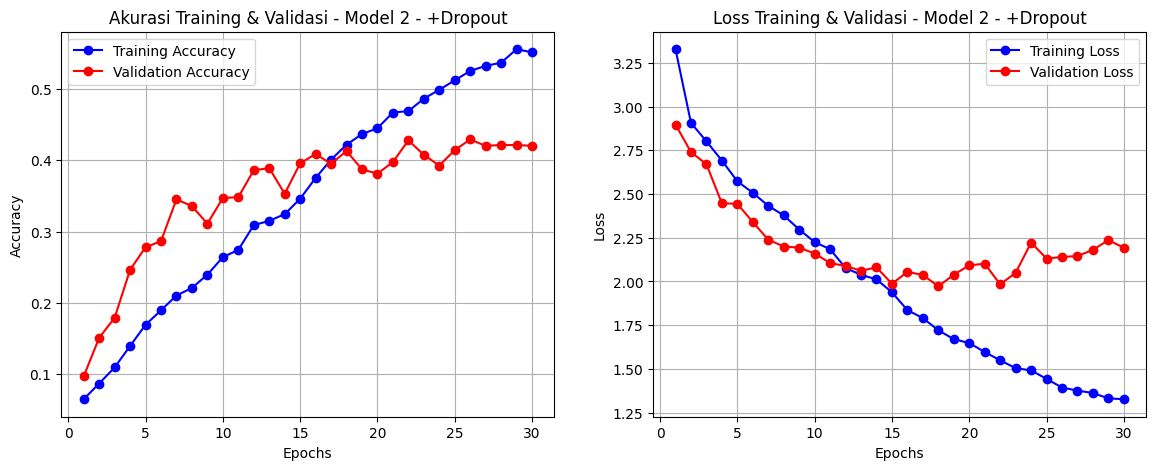

In [24]:
# Sel 24: Plot Hasil Model 2
# (Diambil dari sel '406d4e2d')
plot_history(history_2, "Model 2 - +Dropout")

###**Model 3: Menambah Batch Normalization**

In [25]:
# Sel 25: Definisi Model 3
# (Diambil dari sel '8430e719')

model_3 = Sequential([
    layers.Input(shape=IMG_SHAPE),
    layers.Conv2D(32, 3, use_bias=False, activation='relu'), # use_bias=False sebelum BatchNormalization
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, use_bias=False, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, use_bias=False, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax', dtype=tf.float32)
])

# Sel 26: Kompilasi Model 3
# (Diambil dari sel '196a6035')
model_3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │    11,943,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,965,172 (45.64 MB)

 Trainable params: 11,964,852 (45.64 MB)

 Non-trainable params: 320 (1.25 KB)

In [26]:
# Sel 27: Pelatihan Model 3
# (Diambil dari sel '08719f9f')

print("Memulai pelatihan Model 3...")
# Di file Anda 10 epochs, di prompt Anda 30. Saya gunakan 10, silakan ubah jika perlu.
%time
history_3 = model_3.fit(
    train_dataset_opt,
    epochs=30,
    validation_data=validation_dataset_opt,
    class_weight=class_weights
)

Memulai pelatihan Model 3...
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Epoch 1/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.1416 - loss: 3.2181 - val_accuracy: 0.0665 - val_loss: 3.7900
Epoch 2/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.3512 - loss: 2.1771 - val_accuracy: 0.1229 - val_loss: 3.2683
Epoch 3/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.5426 - loss: 1.5367 - val_accuracy: 0.2596 - val_loss: 2.3347
Epoch 4/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7398 - loss: 0.9467 - val_accuracy: 0.4700 - val_loss: 1.7347
Epoch 5/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.8757 - loss: 0.5301 - val_accuracy: 0.4868 - val_loss: 1.7042
Epoch 6/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9365 - loss: 0.2927 - val_accuracy: 0.4892 - val_loss: 1.7454
Epoch 7/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9718 - loss: 0.1662 - val_accuracy: 0.5246 - val_loss: 1.5164
Epo

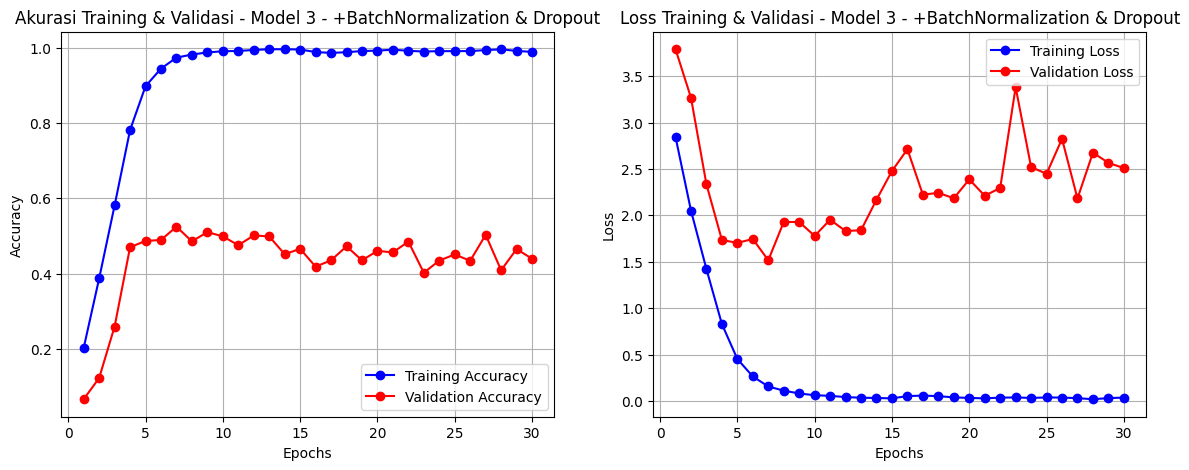

In [27]:
# Sel 28: Plot Hasil Model 3
# (Diambil dari sel '140c2137')
plot_history(history_3, "Model 3 - +BatchNormalization & Dropout")

###**Model 4: Menambah Layer Conv/Dense**

Memulai pelatihan Model 4...
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
Epoch 1/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.2170 - loss: 2.9657 - val_accuracy: 0.0653 - val_loss: 4.5797
Epoch 2/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.4645 - loss: 1.8434 - val_accuracy: 0.1996 - val_loss: 2.8036
Epoch 3/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6097 - loss: 1.3018 - val_accuracy: 0.4862 - val_loss: 1.7879
Epoch 4/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7678 - loss: 0.8285 - val_accuracy: 0.4670 - val_loss: 2.0152
Epoch 5/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8974 - loss: 0.3978 - val_accuracy: 0.5480 - val_loss: 1.5529
Epoch 6/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9583 - loss: 0.1870 - val_accuracy: 0.6139 - val_loss: 1.3365
Epoch 7/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9827 - loss: 0.0991 - val_accuracy: 0.6547 - val_loss: 1.1935
Epo

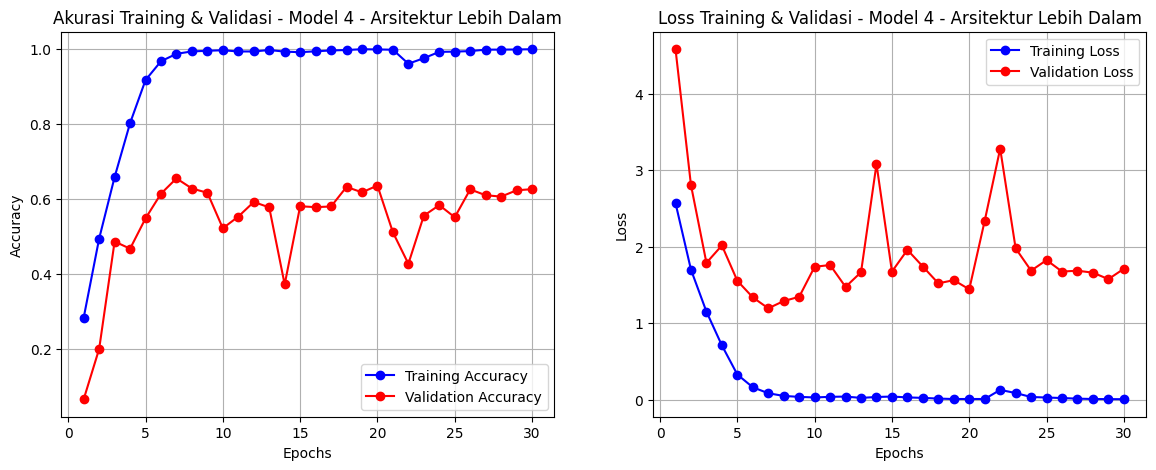

In [28]:
# Sel 29-32: Definisi, Kompilasi, Pelatihan, Plot Model 4
# (Diambil dari sel 'eb46c642', 'df8f0653', '75b9588b', '8b80d0d8')

model_4 = Sequential([
    layers.Input(shape=IMG_SHAPE),
    layers.Conv2D(32, 3, use_bias=False, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, use_bias=False, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, use_bias=False, activation='relu'), # Layer Tambahan
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, use_bias=False, activation='relu'), # Layer Tambahan
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax', dtype=tf.float32)
])

model_4.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Memulai pelatihan Model 4...")
%time
history_4 = model_4.fit(
    train_dataset_opt,
    epochs=30,
    validation_data=validation_dataset_opt,
    class_weight=class_weights
)

plot_history(history_4, "Model 4 - Arsitektur Lebih Dalam")

### **Model 5: Mengubah Optimizer (RMSprop)**

Memulai pelatihan Model 5...
CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs
Epoch 1/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.2180 - loss: 2.9520 - val_accuracy: 0.0719 - val_loss: 4.6355
Epoch 2/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.4852 - loss: 1.7455 - val_accuracy: 0.1996 - val_loss: 3.2944
Epoch 3/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6890 - loss: 1.0602 - val_accuracy: 0.4964 - val_loss: 1.7778
Epoch 4/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8477 - loss: 0.5457 - val_accuracy: 0.5582 - val_loss: 1.5602
Epoch 5/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9331 - loss: 0.2639 - val_accuracy: 0.4454 - val_loss: 2.5866
Epoch 6/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9676 - loss: 0.1397 - val_accuracy: 0.5198 - val_loss: 1.9353
Epoch 7/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9833 - loss: 0.0748 - val_accuracy: 0.5803 - val_loss: 1.5860
Epo

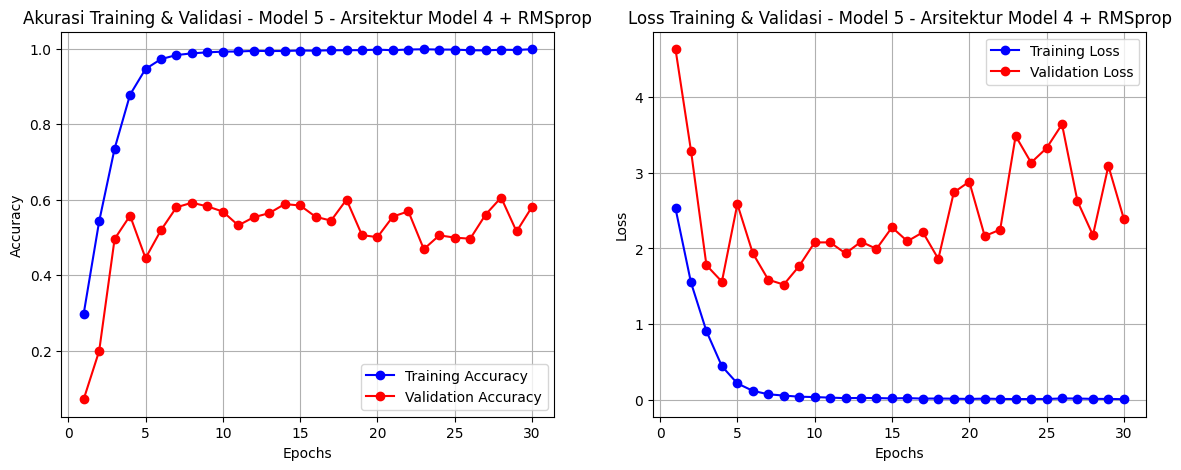

In [29]:
# Sel 33-36: Definisi, Kompilasi, Pelatihan, Plot Model 5
# (Diambil dari sel 'a73a38d2', '99c6be36', '4f964593', 'd32c0211')

# Menggunakan arsitektur Model 4
model_5 = tf.keras.models.clone_model(model_4) # Salin arsitektur

model_5.compile(
    optimizer='rmsprop', # Optimizer diubah
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Memulai pelatihan Model 5...")
%time
history_5 = model_5.fit(
    train_dataset_opt,
    epochs=30,
    validation_data=validation_dataset_opt,
    class_weight=class_weights
)

plot_history(history_5, "Model 5 - Arsitektur Model 4 + RMSprop")

###**Model 6: Menggunakan Learning Rate Scheduler**

Memulai pelatihan Model 6...
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.72 µs
Epoch 1/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.2070 - loss: 3.0404 - val_accuracy: 0.0558 - val_loss: 5.9983
Epoch 2/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.4748 - loss: 1.7557 - val_accuracy: 0.1811 - val_loss: 3.7344
Epoch 3/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6717 - loss: 1.1239 - val_accuracy: 0.2812 - val_loss: 2.8336
Epoch 4/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8087 - loss: 0.6735 - val_accuracy: 0.4077 - val_loss: 2.1820
Epoch 5/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9336 - loss: 0.2854 - val_accuracy: 0.4874 - val_loss: 1.9154
Epoch 6/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9773 - loss: 0.1324 - val_accuracy: 0.6001 - val_loss: 1.4448
Epoch 7/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9878 - loss: 0.0762 - val_accuracy: 0.6121 - val_loss: 1.3817

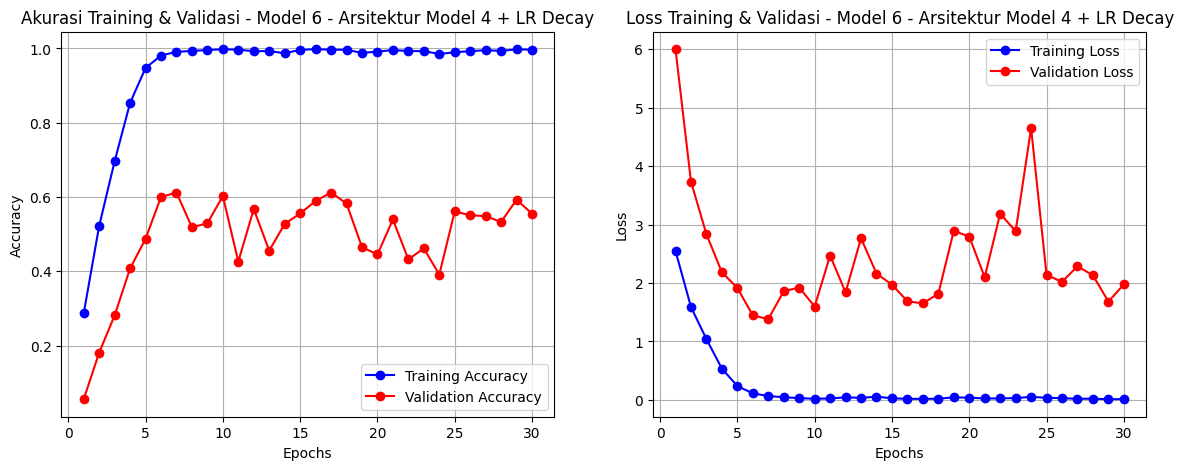

In [30]:
# Sel 37-40: Definisi, Kompilasi, Pelatihan, Plot Model 6
# (Diambil dari sel 'e9854736', 'd2f62779', '94e24ebc', '42c26274')

# Menggunakan arsitektur Model 4 lagi
model_6 = tf.keras.models.clone_model(model_4)

# Learning Rate Scheduler
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)

model_6.compile(
    optimizer=Adam(learning_rate=lr_schedule), # Terapkan scheduler
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Memulai pelatihan Model 6...")
%time
history_6 = model_6.fit(
    train_dataset_opt,
    epochs=30,
    validation_data=validation_dataset_opt,
    class_weight=class_weights
)

plot_history(history_6, "Model 6 - Arsitektur Model 4 + LR Decay")

###**Model 7: Menambah Callback (Early Stopping & ReduceLROnPlateau)**

Memulai pelatihan Model 7...
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Epoch 1/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.1849 - loss: 3.1154 - val_accuracy: 0.0863 - val_loss: 4.7238 - learning_rate: 0.0010
Epoch 2/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.4223 - loss: 1.9627 - val_accuracy: 0.1930 - val_loss: 3.1102 - learning_rate: 0.0010
Epoch 3/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6013 - loss: 1.3056 - val_accuracy: 0.5102 - val_loss: 1.6925 - learning_rate: 0.0010
Epoch 4/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.7726 - loss: 0.8067 - val_accuracy: 0.5306 - val_loss: 1.5902 - learning_rate: 0.0010
Epoch 5/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9041 - loss: 0.4023 - val_accuracy: 0.4700 - val_loss: 1.8946 - learning_rate: 0.0010
Epoch 6/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9552 - loss: 0.1925 - val_accuracy: 0.6037 - val_loss: 1.3623 - learning_r

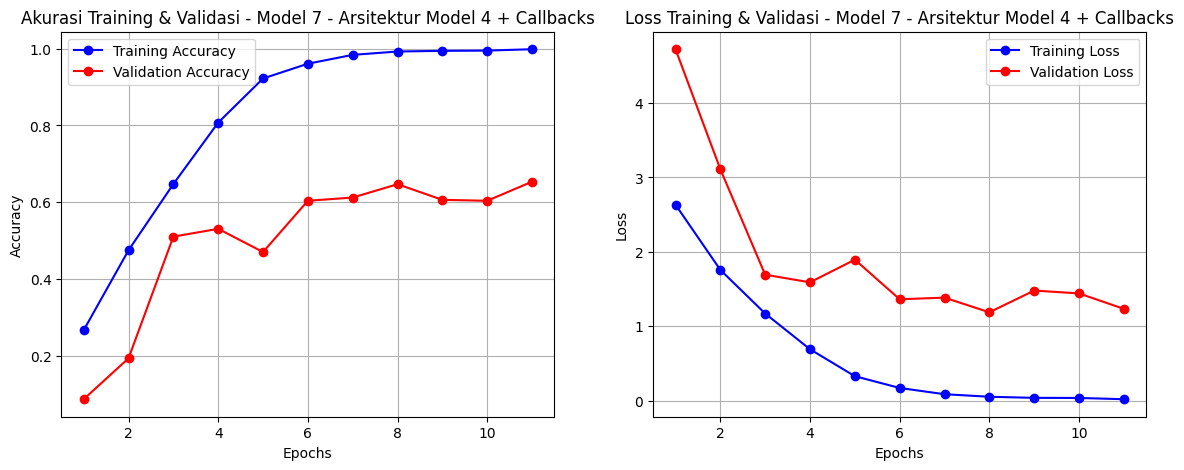

In [31]:
  # Sel 41-44: Definisi, Kompilasi, Pelatihan, Plot Model 7
# (Diambil dari sel 'd31b0177', 'b18d2d99', '280d46dd', 'e46e8f49')

# Menggunakan arsitektur Model 4
model_7 = tf.keras.models.clone_model(model_4)

model_7.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Definisikan Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

print("Memulai pelatihan Model 7...")
%time
history_7 = model_7.fit(
    train_dataset_opt,
    epochs=30, # Di sini saya  pakai 30 epochs, karena cocok untuk Early Stopping
    validation_data=validation_dataset_opt,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr] # Tambahkan callbacks
)

plot_history(history_7, "Model 7 - Arsitektur Model 4 + Callbacks")

###**Model 8: Transfer Learning (MobileNetV2)**

In [32]:
from tensorflow.keras.applications import MobileNetV2

# Sel 45: Definisi Base Model 8
base_model = MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

# Sel 46: Definisi Model 8 Lengkap
inputs = layers.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
# --- PERBAIKAN DI SINI ---
outputs = layers.Dense(len(class_names), activation='softmax', dtype=tf.float32)(x) # Menggunakan 'x' sebagai input

model_8 = Model(inputs, outputs)

# Sel 47: Kompilasi Model 8
model_8.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_8.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,424,532 (9.25 MB)

 Trainable params: 166,548 (650.58 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
# Sel 48: Pelatihan Model 8 (Feature Extraction)
# (Diambil dari sel '140e4f8d')

print("Memulai pelatihan Model 8 (Feature Extraction)...")
%time
history_8 = model_8.fit(
    train_dataset_opt,
    epochs=30,
    validation_data=validation_dataset_opt,
    class_weight=class_weights
)

Memulai pelatihan Model 8 (Feature Extraction)...
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
Epoch 1/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 98s 321ms/step - accuracy: 0.4800 - loss: 1.7734 - val_accuracy: 0.8753 - val_loss: 0.4291
Epoch 2/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8468 - loss: 0.5122 - val_accuracy: 0.9293 - val_loss: 0.2493
Epoch 3/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9052 - loss: 0.3070 - val_accuracy: 0.9353 - val_loss: 0.2057
Epoch 4/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9304 - loss: 0.2322 - val_accuracy: 0.9430 - val_loss: 0.1800
Epoch 5/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9498 - loss: 0.1811 - val_accuracy: 0.9478 - val_loss: 0.1623
Epoch 6/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9509 - loss: 0.1494 - val_accuracy: 0.9436 - val_loss: 0.1679
Epoch 7/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9569 - loss: 0.1406 - val_accuracy: 0.9490 -

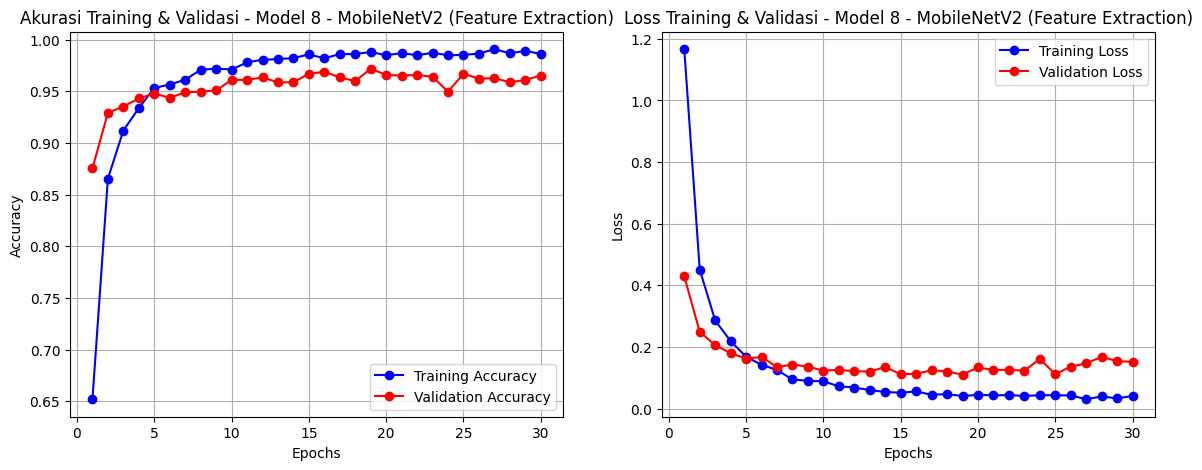

In [34]:
# Sel 49: Plot Hasil Model 8
# (Diambil dari sel '2ce75c5e')
plot_history(history_8, "Model 8 - MobileNetV2 (Feature Extraction)")

In [35]:
# Sel 50: Unfreeze untuk Fine-Tuning
# (Diambil dari sel '906b3a0e' & '067c2901')

base_model.trainable = True # Buka kunci base model

# Fine-tune dari layer ke-100
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Kompilasi ulang dengan LR sangat rendah
model_8.compile(
    optimizer=Adam(learning_rate=1e-5), # LR rendah untuk fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_8.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,424,532 (9.25 MB)

 Trainable params: 2,027,988 (7.74 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [36]:
# Sel 51: Pelatihan Model 8 (Fine-Tuning)
# (Diambil dari sel '5d09b6ca')

print("Memulai pelatihan Model 8 (Fine-Tuning)...")
initial_epochs = 30 # Epochs dari tahap sebelumnya
fine_tune_epochs = 30 # Epochs tambahan
total_epochs = initial_epochs + fine_tune_epochs

%time
history_8_fine_tune = model_8.fit(
    train_dataset_opt,
    epochs=total_epochs,
    initial_epoch=initial_epochs, # Lanjutkan dari epoch sebelumnya
    validation_data=validation_dataset_opt,
    class_weight=class_weights
)

Memulai pelatihan Model 8 (Fine-Tuning)...
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Epoch 31/60
209/209 ━━━━━━━━━━━━━━━━━━━━ 121s 323ms/step - accuracy: 0.4623 - loss: 4.8447 - val_accuracy: 0.9436 - val_loss: 0.2748
Epoch 32/60
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7466 - loss: 1.1258 - val_accuracy: 0.9532 - val_loss: 0.2467
Epoch 33/60
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8143 - loss: 0.7242 - val_accuracy: 0.9508 - val_loss: 0.2390
Epoch 34/60
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8624 - loss: 0.4942 - val_accuracy: 0.9514 - val_loss: 0.2297
Epoch 35/60
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8798 - loss: 0.3729 - val_accuracy: 0.9550 - val_loss: 0.2137
Epoch 36/60
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9124 - loss: 0.2728 - val_accuracy: 0.9556 - val_loss: 0.2087
Epoch 37/60
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9387 - loss: 0.1953 - val_accuracy: 0.9556

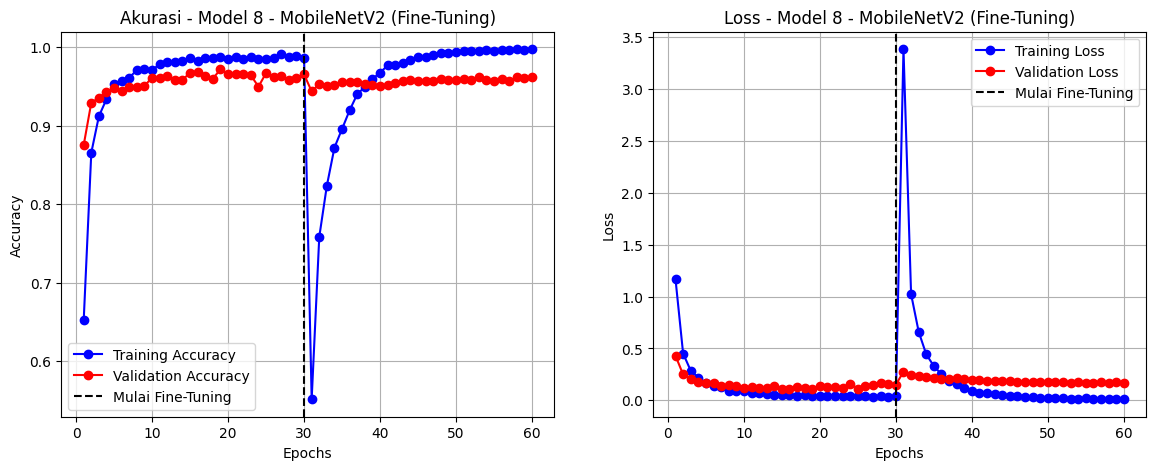

In [37]:
# Sel 52: Plot Hasil Model 8 (Fine-Tuning)
# (Diambil dari sel 'c838e55c')
# (Fungsi ini tidak ada di file, saya buatkan)
def plot_fine_tune_history(original_history, fine_tune_history, title):
    """Menggabungkan dan memplot history dari feature extraction dan fine-tuning."""
    acc = original_history.history['accuracy'] + fine_tune_history.history['accuracy']
    val_acc = original_history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
    loss = original_history.history['loss'] + fine_tune_history.history['loss']
    val_loss = original_history.history['val_loss'] + fine_tune_history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.axvline(original_history.epoch[-1] + 1, linestyle='--', color='k', label='Mulai Fine-Tuning')
    plt.title(f'Akurasi - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.axvline(original_history.epoch[-1] + 1, linestyle='--', color='k', label='Mulai Fine-Tuning')
    plt.title(f'Loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_fine_tune_history(history_8, history_8_fine_tune, "Model 8 - MobileNetV2 (Fine-Tuning)")

##Tahap 10: Evaluasi & Simpan Model Final (dari file Anda)
Ini adalah bagian akhir dari notebook Anda, di mana Anda memilih model terbaik (Model 3) dan menyimpannya.

In [38]:
# Sel 53: Pilih Model Final
# (Diambil dari sel '092003c4')

# Di notebook Anda, Anda memilih Model 3 sebagai yang terbaik.
model_final = model_3
history_final = history_3

print("Model 3 dipilih sebagai model final.")

Model 3 dipilih sebagai model final.


Mengevaluasi model pada data tes...
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 0.3813 - loss: 2.5614
Test Loss: 2.4954
Test Accuracy: 0.4000


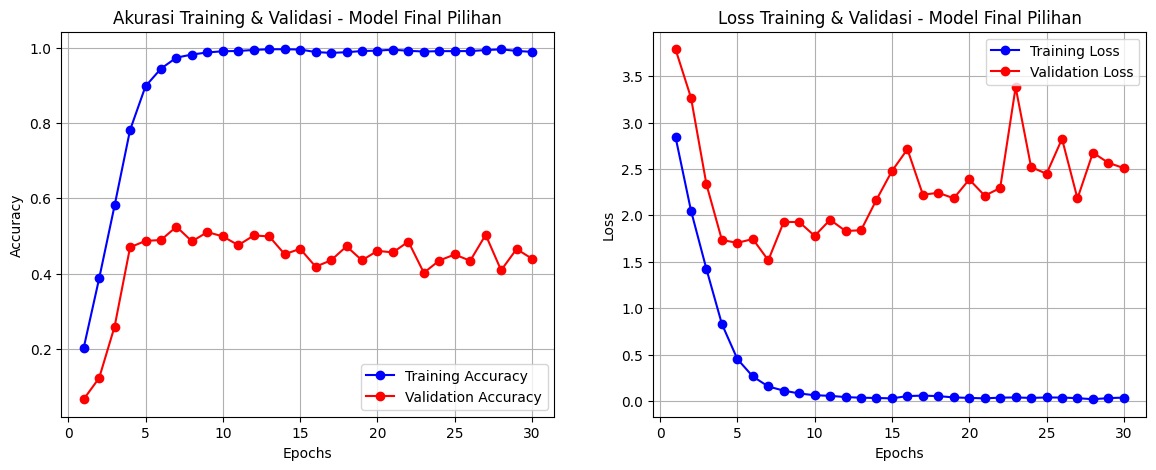

Membuat prediksi pada data tes...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


In [39]:
# Sel 54: Fungsi Evaluasi
# (Diambil dari sel '9f4b7a14')

def evaluate_model(model, test_data, history):
    print("Mengevaluasi model pada data tes...")
    loss, accuracy = model.evaluate(test_data)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Tampilkan plot history dari model yang dipilih
    plot_history(history, "Model Final Pilihan")

    # Prediksi
    print("Membuat prediksi pada data tes...")
    y_pred_probs = model.predict(test_data)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Ekstrak label asli
    y_true = []
    for _, labels in test_data:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)

    return y_true, y_pred

# Panggil fungsi evaluasi
y_true, y_pred = evaluate_model(model_final, test_dataset_opt, history_final)

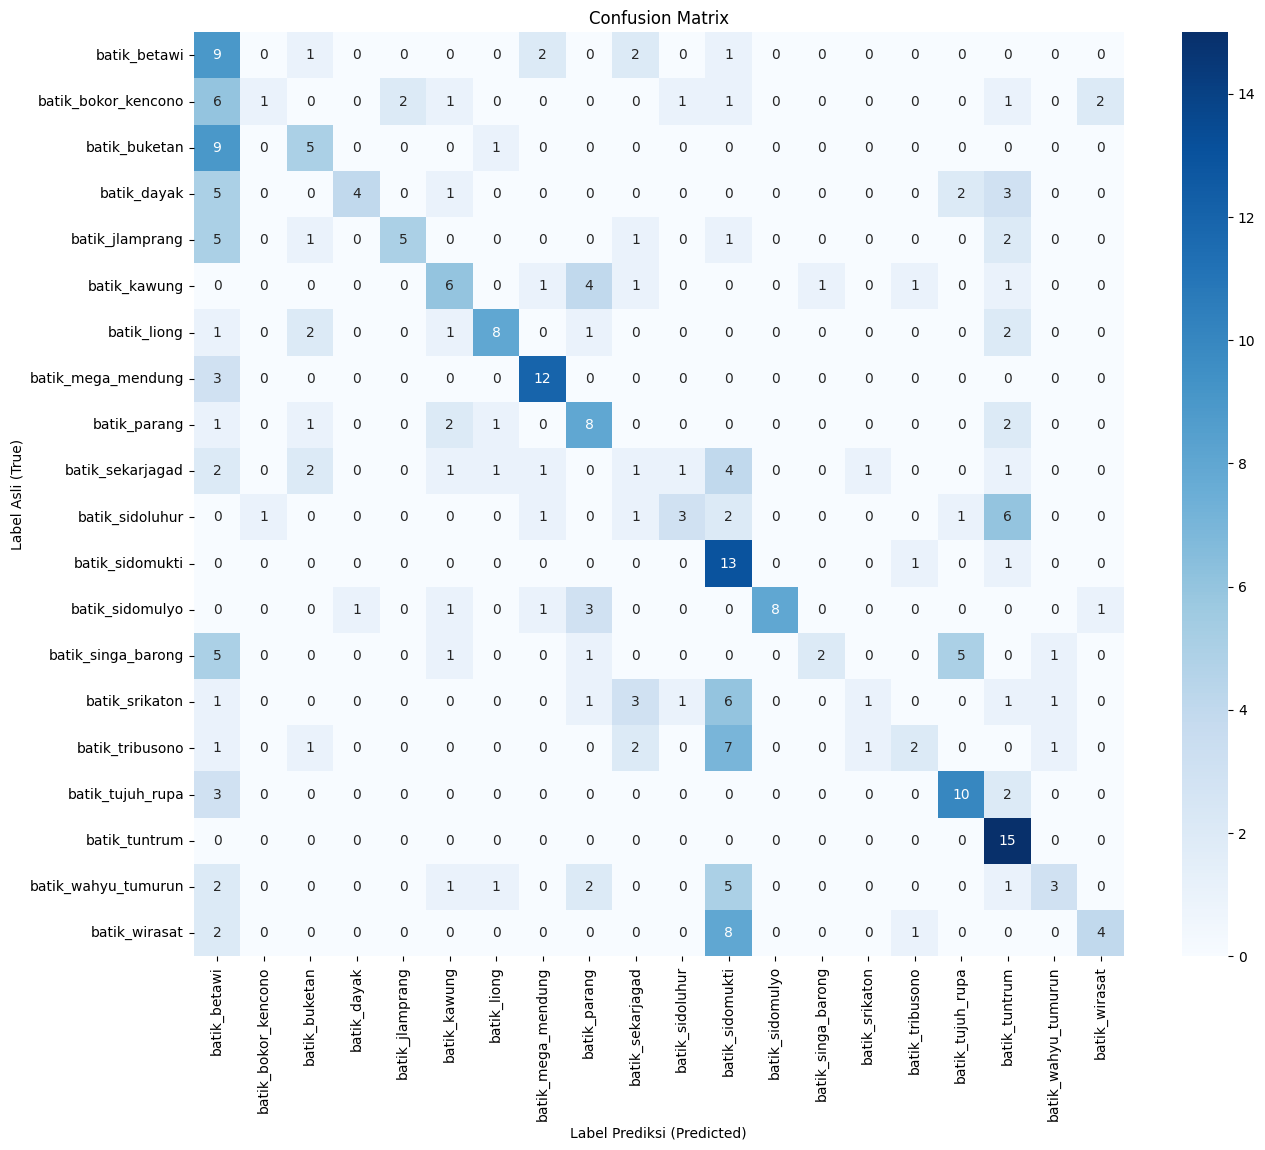

In [40]:
# Sel 55: Plot Confusion Matrix
# (Diambil dari sel '55ffdae5', butuh definisi 'plot_confusion_matrix')
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('Label Asli (True)')
    plt.xlabel('Label Prediksi (Predicted)')
    plt.show()

# Tampilkan Confusion Matrix
plot_confusion_matrix(y_true, y_pred, class_names)

In [41]:
# Sel 56: Tampilkan Classification Report
# (Diambil dari sel '5f2f9f1b')
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:

                     precision    recall  f1-score   support

       batik_betawi       0.16      0.60      0.26        15
batik_bokor_kencono       0.50      0.07      0.12        15
      batik_buketan       0.38      0.33      0.36        15
        batik_dayak       0.80      0.27      0.40        15
    batik_jlamprang       0.71      0.33      0.45        15
       batik_kawung       0.40      0.40      0.40        15
        batik_liong       0.67      0.53      0.59        15
 batik_mega_mendung       0.67      0.80      0.73        15
       batik_parang       0.40      0.53      0.46        15
   batik_sekarjagad       0.09      0.07      0.08        15
    batik_sidoluhur       0.50      0.20      0.29        15
    batik_sidomukti       0.27      0.87      0.41        15
    batik_sidomulyo       1.00      0.53      0.70        15
 batik_singa_barong       0.67      0.13      0.22        15
     batik_srikaton       0.33      0.07      0.11        15

In [42]:
# Sel 57: Simpan Model Final ke Google Drive
# (Modifikasi dari sel '02e4249a')

# Path di Google Drive Anda
save_path = "/content/drive/MyDrive/ProyekBatik/model_batik_cnn_v1.keras"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

print(f"Menyimpan model final ke: {save_path}")
model_final.save(save_path)
print("Model berhasil disimpan ke Google Drive Anda.")

Menyimpan model final ke: /content/drive/MyDrive/ProyekBatik/model_batik_cnn_v1.keras
Model berhasil disimpan ke Google Drive Anda.


## Tahap 11: Menyimpan output Google Colabs ke dalam project 

1. Download file model_batik_cnn_v1.keras dari drive
2. buat folder bernama /model di dalam projek
3. simpan model_batik_cnn_v1.keras di dalam /model